# Cross LULC Zone change Matrix and NDVI Zone change Matrix

In [1]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import os
import datacube
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray 

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import rcParams

from datacube.utils.cog import write_cog


In [2]:
# Set important parameters for the analysis.

# Directory where the results from previous notebooks are stored in.
output_dir = "results"

# Select an African country to carry out the analysis over.
country = "Tunisia"

# Select the initial and follow up year for change detection used in the previous notebooks.
initial_year = "2015"
followup_year = "2019"

## Cross LULC and NDVI Change Map

In [3]:
# Load the LULC change xarray.DataArray for the initial and follow up year defined above.
lulc_change_fn = f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_lulc_change_detection.tif"

lulc_change = rioxarray.open_rasterio(lulc_change_fn).squeeze()

In [4]:
# Load the NDVI change xarray.DataArray for the initial and follow up year defined above.
ndvi_change_fn =f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_ndvi_change_detection.tif"

ndvi_change = rioxarray.open_rasterio(ndvi_change_fn).squeeze()

In [5]:
# Define the labels and values for the change classes for the comparison of the LULC and NDVI change xarray.DataArrays.
change_labels = ["Stable", "Bad", "Mediocre", "Good", "Excellent"]
change_classes = [0, 0.5, 1.0, 1.5, 2.0]
# Define the colors to be used to represent the change classes.
change_colors = ["#E5D1EF", "orange", "red", "#A8CD66", "green"]

change_class_dict = dict(zip(change_labels, change_classes))

In [6]:
# To compare the LULC and NDVI change arrays
# add the two arrays and divide the results by 2.
ds_change = (lulc_change + ndvi_change) / 2

In [7]:
# Export the change xarray.DataArray as a GeoTIFF.
fname = f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_cross_lulc_ndvi_change_detection.tif"

# Write GeoTIFF. 
write_cog(ds_change, fname=fname, overwrite=True)

PosixPath('results/2015_2019_Tunisia_cross_lulc_ndvi_change_detection.tif')

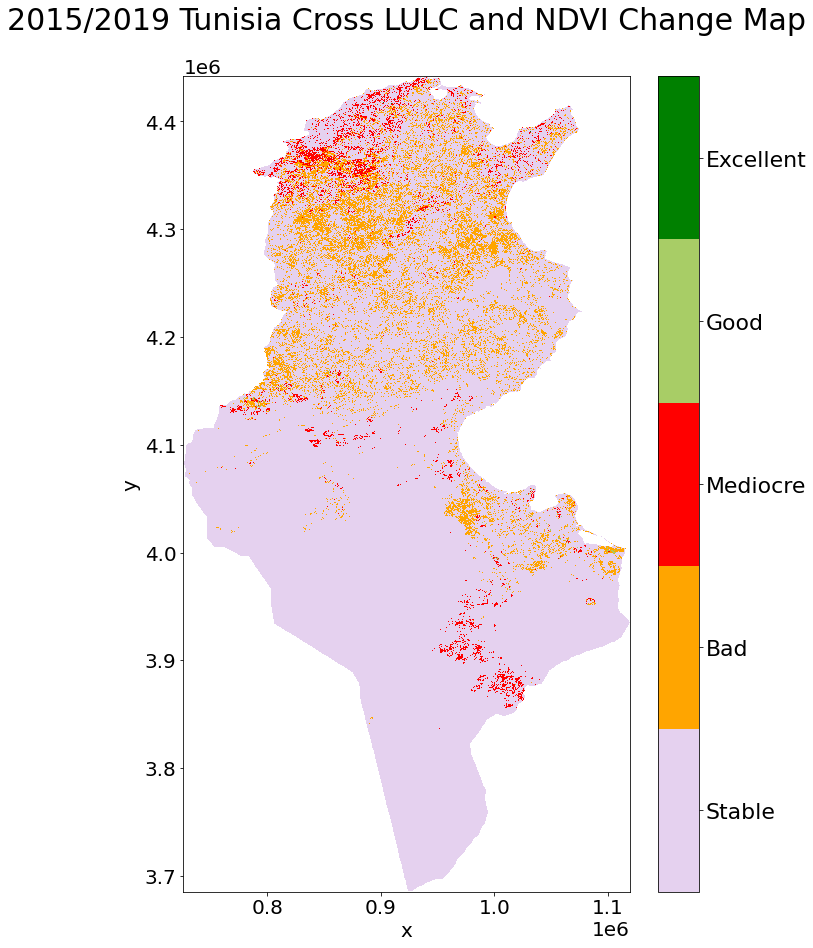

In [8]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 20})

# Define the color map to use to plot the cross LULC and NDVI change map.
cmap = mcolors.ListedColormap(colors=change_colors, N=len(change_classes))
bounds = np.arange(min(change_classes) - 0.25, max(change_classes) + 0.5, 0.5)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the cross LULC and NDVI change detection xarray.DataArray.
fig , ax = plt.subplots(figsize=(10, 15))
im = ds_change.plot(add_colorbar=False, ax=ax, cmap=cmap, norm=norm)
# Type of notation on the axes.
ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
plt.title(f"{initial_year}/{followup_year} {country} Cross LULC and NDVI Change Map", y=1.05, ha="center", size=30)

# Color bar.
cbar = plt.colorbar(im, ticks=change_classes)
cbar.set_ticklabels(change_labels)
cbar.ax.tick_params(labelsize=22)

plt.savefig(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_lulc_change_detection.png")
plt.show()

In [9]:
# Get the resolution i.e. actual ground distance represented by the length of a single pixel in meters.
pixel_length = ds_change.geobox.resolution[1]
# Conversion from metres sqaured to hectares.
m2_per_ha = 10000
# Get the actual ground area represented by each pixel.
area_per_pixel = (pixel_length ** 2) / m2_per_ha

In [10]:
# Get the area for each change class.

# Use the numpy np.unique function to return the pixel count for each change class.
counts = np.unique(ds_change, return_counts=True)
# Calculate the area of each change class.
# Remove the last value as it represents the area of pixels with the value np.nan.
area = np.array(counts[1] * area_per_pixel)[:-1]

# Store the results as a dictionary.
results = dict(zip(change_labels, area))

# Convert the results dictionary to a pandas DataFrame. 
results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Area (hectares)"])
results_df

,Area (hectares)
Stable,13433094.0
Bad,1609650.0
Mediocre,396855.0
Good,9495.0
Excellent,729.0


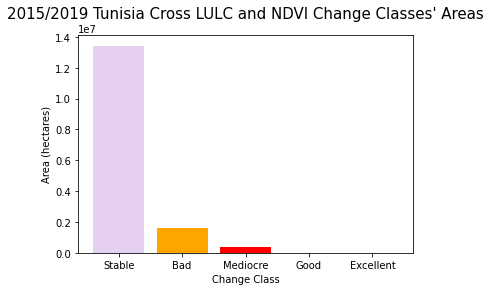

In [11]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 10})

fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.bar(x=results_df.index, height=results_df["Area (hectares)"], color=change_colors)
# Set the x and y axis labels.
subplot.set_xlabel("Change Class")
subplot.set_ylabel("Area (hectares)")
# Set the title. 
subplot.set_title(f"{initial_year}/{followup_year} {country} Cross LULC and NDVI Change Classes' Areas", y=1.05, size=15)
# Type of notation on the axes.
subplot.ticklabel_format(axis="y", style='scientific', scilimits=(0, 0))

plt.savefig(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_cross_lulc_ndvi_change_areas.png");

## Cross LULC and NDVI Change Matrix

In [12]:
# Change the default decimal precision used for printing dataframes.
pd.set_option("display.precision", 2)

# Styling function to change the background of a cell in a pandas dataframe.  
def cross_matrix_set_background_color(df):

    # Define the background colors to be used for the input dataframe cells.
    # based on the type of change.
    red = "background-color : red"
    purple = "background-color : #E5D1EF"
    orange = "background-color : orange"
    light_green = "background-color : #A8CD66"
    green = "background-color : green"

    # Create a copy of the input dataframe. 
    df1 = df.copy(deep=True)
    
    row_fill_value = df1.index[0][0]
    column_fill_value = df1.columns[0][0]
    
    # Define the color code for the types of changes.
    df1.loc[(row_fill_value, "Bad"), (column_fill_value, "Bad")] = red
    df1.loc[(row_fill_value, "Bad"), (column_fill_value, "Stable")] = orange
    df1.loc[(row_fill_value, "Bad"), (column_fill_value, "Excellent")] = light_green
    df1.loc[(row_fill_value, "Stable"), (column_fill_value, "Bad")] = orange
    df1.loc[(row_fill_value, "Stable"), (column_fill_value, "Stable")] = purple
    df1.loc[(row_fill_value, "Stable"), (column_fill_value, "Excellent")] = red
    df1.loc[(row_fill_value, "Excellent"), (column_fill_value, "Bad")] = light_green
    df1.loc[(row_fill_value, "Excellent"), (column_fill_value, "Stable")] = red
    df1.loc[(row_fill_value, "Excellent"), (column_fill_value, "Excellent")] = green

    return df1

# Styling function to add a title to a pandas dataframe.
def make_pretty(styler, title):
    # Add a title to the dataframe.
    styler.set_caption(title)
    # Increase font size and bold the dataframe title.
    title_style = dict(selector="caption", props=[("text-align", "right"), 
                                                  ("font-weight", "bold"), 
                                                  ("font-size", "14px")])
    # Rotate the level 0 row labels.
    row_labels_style = dict(selector="th.row_heading.level0", props=[("text-align", "left"),
                                                                     ("width", "100px")])
    
    column_labels_style = dict(selector="th.column_heading.level0", props=[("text-align", "left")])
    
    styler.set_table_styles([title_style, row_labels_style])
    return styler

In [13]:
# Create the reference Cross LULC zone change and NDVI zone change matrix.

row_labels_level1 = ["Bad", "Stable", "Excellent"]
row_fill_value = "LULC Zone Change Matrix Result"
row_labels_level0 = np.full(shape=len(row_labels_level1), fill_value=row_fill_value)
row_labels_tuples = list(zip(row_labels_level0, row_labels_level1))
row_labels = pd.MultiIndex.from_tuples(row_labels_tuples)

column_labels_level1 = ["Bad", "Stable", "Excellent"]
column_fill_value = "NDVI Zone Change Matrix Result"
column_labels_level0 = np.full(shape=len(column_labels_level1), fill_value=column_fill_value)
column_labels_tuples = list(zip(column_labels_level0, column_labels_level1))
column_labels = pd.MultiIndex.from_tuples(column_labels_tuples)

# Create an empty dataframe.
ref_cross_matrix = pd.DataFrame(data=" ", index=row_labels, columns=column_labels)

# Define the types of changes.
ref_cross_matrix.loc[(row_fill_value, "Bad"), (column_fill_value, "Bad")] = "Mediocre"
ref_cross_matrix.loc[(row_fill_value, "Bad"), (column_fill_value, "Stable")] = "Bad"
ref_cross_matrix.loc[(row_fill_value, "Bad"), (column_fill_value, "Excellent")] = "Good"
ref_cross_matrix.loc[(row_fill_value, "Stable"), (column_fill_value, "Bad")] = "Bad"
ref_cross_matrix.loc[(row_fill_value, "Stable"), (column_fill_value, "Stable")] = "Stable"
ref_cross_matrix.loc[(row_fill_value, "Stable"), (column_fill_value, "Excellent")] = "Mediocre"
ref_cross_matrix.loc[(row_fill_value, "Excellent"), (column_fill_value, "Bad")] = "Good"
ref_cross_matrix.loc[(row_fill_value, "Excellent"), (column_fill_value, "Stable")] = "Mediocre"
ref_cross_matrix.loc[(row_fill_value, "Excellent"), (column_fill_value, "Excellent")] = "Excellent"

# Style the dataframe.
ref_cross_matrix = ref_cross_matrix.style.apply(cross_matrix_set_background_color, axis=None).pipe(make_pretty, title="Reference Cross LULC and NDVI Zone Change matrix")

In [14]:
# Generate the Cross LULC and NDVI Zone Change Matrix.
cross_matrix = ref_cross_matrix.data.copy(deep=True)

for change_class in change_labels:
    cross_matrix.replace(to_replace=change_class, value=results[change_class], inplace=True) 
                         
cross_matrix = cross_matrix.style.apply(cross_matrix_set_background_color, axis=None).pipe(make_pretty, title=f"{initial_year} to {followup_year} {country} Cross LULC and NDVI Zone Change matrix (hectares)")                         

In [15]:
display(ref_cross_matrix)

In [16]:
display(cross_matrix)

In [17]:
# Export the above Cross LULC and NDVI zone change matrices as csv files.
ref_cross_matrix.data.to_csv(f"{output_dir}/{country.replace(' ', '')}_reference_cross_change_matrix.csv", index=False)
cross_matrix.data.to_csv(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_cross_change_matrix.csv", index=False)